# BTC ML/DL Trading strategy

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [3]:
from src.Utils import *

## Preliminary data import & handling

In [12]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [13]:
# Deepcopying
df_ = df.copy(deep=True)

**Reference**:
1. https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [7]:
# Getting correlation of lagged-series
#pd.DataFrame(data={"a": df["Close"], "b": df["Close"].shift(1)}).corr()

In [14]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [15]:
# Resampling to 10-min bins
df = df.resample("10T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="bfill", inplace=True)

In [16]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,437.0,13835.194,14052.3,13501.01,13720.260,60.545301,13756.177556
2018-01-01 00:10:00,301.0,13713.610,13948.6,13400.01,13626.110,49.918511,13665.050348
2018-01-01 00:20:00,308.0,13626.248,13826.8,13410.44,13648.280,53.002165,13623.876888
2018-01-01 00:30:00,228.5,13638.620,13800.0,13461.74,13636.600,36.841839,13652.429477
2018-01-01 00:40:00,245.0,13649.296,13800.0,13450.00,13693.004,48.451182,13640.833680


In [17]:
# Some statistical analysis
df.describe()

,Count,Open,High,Low,Close,Volume,VWAP
count,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000
mean,1036.575761,18706.849538,18780.568915,18636.490972,18706.957485,89.569931,18706.905651
std,1279.367076,17863.740822,17904.317644,17814.076700,17863.726108,114.678865,17863.725743
min,1.000000,3153.860000,3232.600000,3120.000000,3160.405000,0.001104,3159.199122
25%,318.000000,7124.448333,7159.000000,7098.480000,7124.657143,36.544792,7124.256692
50%,614.000000,9504.030000,9530.000000,9476.660000,9503.897143,57.727493,9503.429433
75%,1311.500000,32225.492857,32361.000000,32084.715549,32225.264388,98.577041,32221.782272
max,55717.500000,68716.598333,69024.200000,68447.000000,68724.006667,3985.862343,68619.267512


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [18]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [19]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

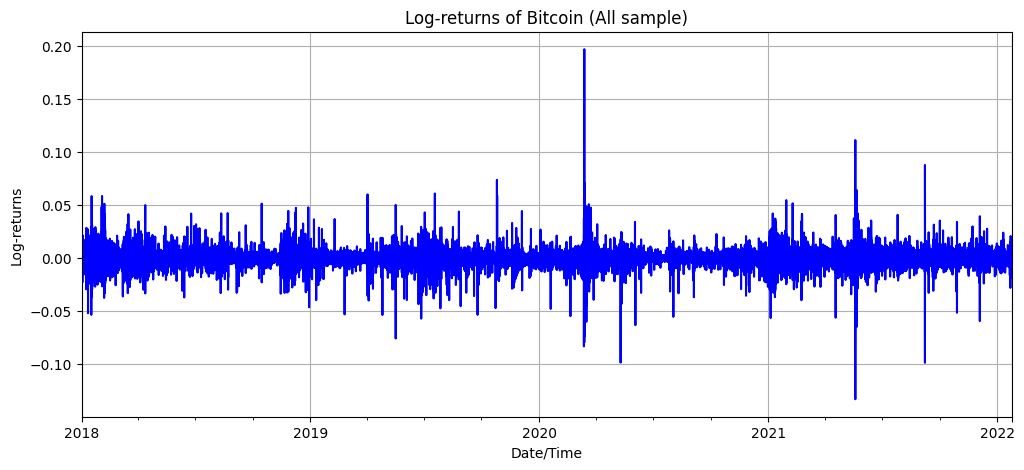

In [20]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

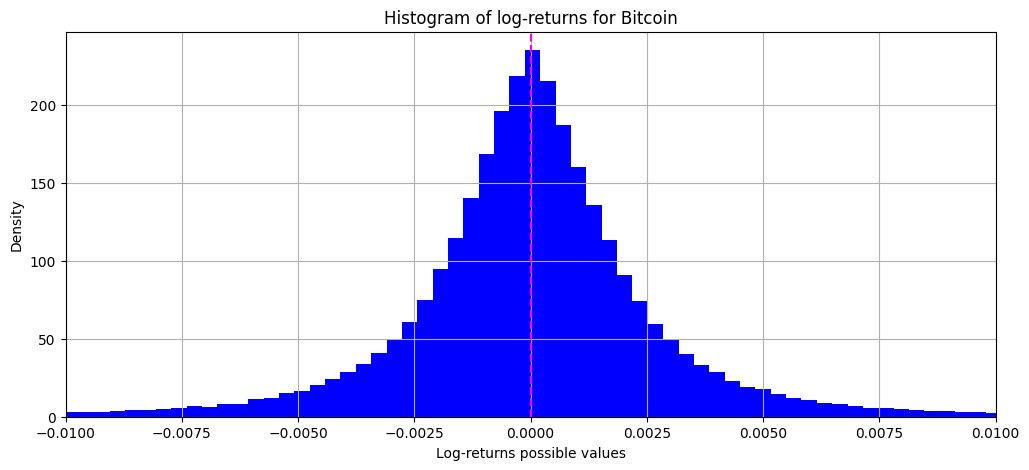

In [21]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [22]:
def rsi(df, periods = 10, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    # Computing the Close price delta
    close_delta = df["Close"].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
    
    # Computing the RSI
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [23]:
# Computing Rolled average close price
#df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
#df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
#df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
#df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = rsi(df)

# Computing the Bollinger Bands (BB) indicators
#upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
#                                          nbdevup=2,
#                                          nbdevdn=2,
#                                          timeperiod=20)
#df["BBANDS_U"] = upper_2sd
#df["BBANDS_M"] = mid_2sd
#df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
#df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
#df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

# TODO: Adding other technical analysis indicator
# Momentum
# Standard deviation
# ...

In [24]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

10

In [25]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,RSI,SMA_SLOW
timestamp,,,,,,,,,,,
2018-01-01 01:40:00,387.5,13566.290,13615.0,13349.00,13427.670,86.495359,13470.400785,5,-0.010281,24.021885,13559.8084
2018-01-01 01:50:00,464.0,13430.210,13600.0,13155.38,13336.952,89.835675,13394.581464,5,-0.006779,19.572667,13517.0204
2018-01-01 02:00:00,330.0,13337.022,13600.0,13202.03,13417.432,57.790558,13406.334718,5,0.006016,31.989348,13471.9472
2018-01-01 02:10:00,251.0,13409.678,13600.0,13228.02,13367.392,41.307211,13433.057391,5,-0.003736,28.906294,13423.1756
2018-01-01 02:20:00,176.0,13367.302,13525.3,13225.00,13348.502,34.057180,13385.013468,5,-0.001414,27.783166,13379.5896


### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [26]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,RSI,SMA_SLOW
timestamp,,,,,,,,,,,
2018-01-01 01:40:00,387.5,13566.290,13615.0,13349.00,13427.670,86.495359,13470.400785,5,-0.010281,24.021885,13559.8084
2018-01-01 01:50:00,464.0,13430.210,13600.0,13155.38,13336.952,89.835675,13394.581464,5,-0.006779,19.572667,13517.0204
2018-01-01 02:00:00,330.0,13337.022,13600.0,13202.03,13417.432,57.790558,13406.334718,5,0.006016,31.989348,13471.9472
2018-01-01 02:10:00,251.0,13409.678,13600.0,13228.02,13367.392,41.307211,13433.057391,5,-0.003736,28.906294,13423.1756
2018-01-01 02:20:00,176.0,13367.302,13525.3,13225.00,13348.502,34.057180,13385.013468,5,-0.001414,27.783166,13379.5896


In [28]:
# Computation of the target
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

In [29]:
# X/Y split - Splitting the dataset into X/Y
# X = features, 
# Y = target
X = df.copy() # X as a deep copy for security reason
Y = X.pop("Target")

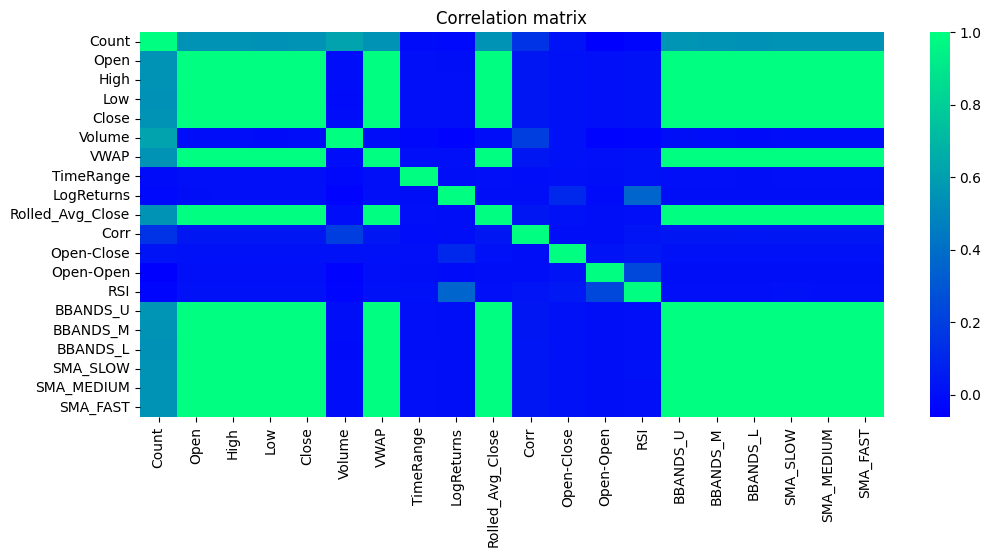

In [21]:
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap="winter")
_ = plt.title("Correlation matrix")

In [22]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['High', 'Low', 'Close', 'VWAP', 'Rolled_Avg_Close', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'SMA_SLOW', 'SMA_MEDIUM', 'SMA_FAST']


In [23]:
# Drop highly correlated features
to_drop = ["Open", "High", "Low", "VWAP", "Rolled_Avg_Close", "BBANDS_U", "BBANDS_M", "BBANDS_L", "SMA_SLOW", "SMA_MEDIUM", "SMA_FAST"]
try:
    if len(to_drop) != 0:
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except KeyError as e:
    print("High-correlated features already removed")

Removing high-correlated columns


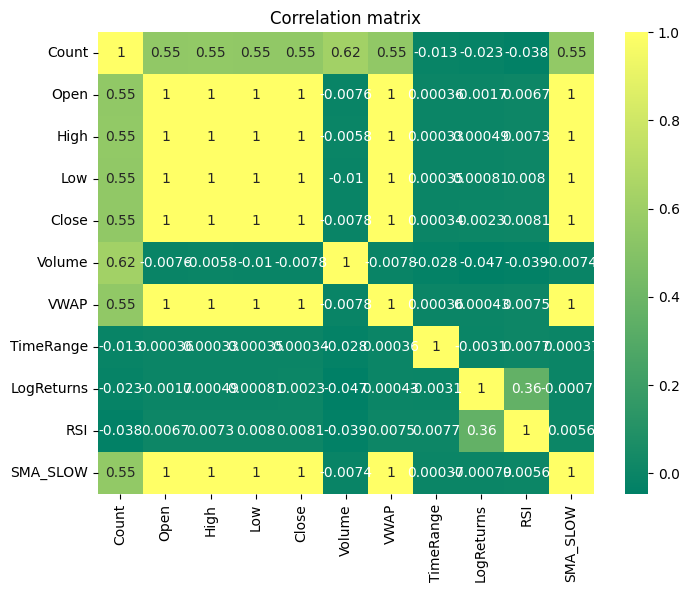

In [33]:
_ = plt.figure(figsize=(8, 6))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="summer")
_ = plt.title("Correlation matrix")

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Defining the scaler pre-processor
scaler = MinMaxScaler()

# 
X_train_scaled = scaler.fit_transform(X_train)

# Defining the classifier model
model = SVC()

# Fitting the model with the dataset
model.fit(X_train_scaled, y_train)

# Transforming the 
X_test_scaled = scaler.transform(X_test)

# Predicting 
y_pred = model.predict(X_test_scaled)

SyntaxError: trailing comma not allowed without surrounding parentheses (276951963.py, line 2)

In [48]:
# Train/Test/Validation split
# Splitting into Train/Test split 
tss = TimeSeriesSplit(n_splits = int(1e4), gap=0, test_size=1) # for timeseries cross validation

# Retrieving X_train, X_test, Y_train & Y_test
for i, (train_index, test_index) in enumerate(tss.split(X)):
    #print(i)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    #print(X_train["Close"])
    #print(">>>> CONTINU <<<<")
    print(i, X_test["Close"].index)
    #print("#"*60)
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

0 DatetimeIndex(['2021-11-15 13:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1 DatetimeIndex(['2021-11-15 13:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2 DatetimeIndex(['2021-11-15 13:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3 DatetimeIndex(['2021-11-15 14:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4 DatetimeIndex(['2021-11-15 14:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5 DatetimeIndex(['2021-11-15 14:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6 DatetimeIndex(['2021-11-15 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7 DatetimeIndex(['2021-11-15 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8 DatetimeIndex(['2021-11-15 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9 DatetimeIndex(['2021-11-15 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
10 DatetimeIndex(['2021-11-15 15:10:00'], dtype='d

100 DatetimeIndex(['2021-11-16 06:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
101 DatetimeIndex(['2021-11-16 06:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
102 DatetimeIndex(['2021-11-16 06:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
103 DatetimeIndex(['2021-11-16 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
104 DatetimeIndex(['2021-11-16 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
105 DatetimeIndex(['2021-11-16 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
106 DatetimeIndex(['2021-11-16 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
107 DatetimeIndex(['2021-11-16 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
108 DatetimeIndex(['2021-11-16 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
109 DatetimeIndex(['2021-11-16 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
110 DatetimeIndex(['2021-11-16

209 DatetimeIndex(['2021-11-17 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
210 DatetimeIndex(['2021-11-17 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
211 DatetimeIndex(['2021-11-17 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
212 DatetimeIndex(['2021-11-17 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
213 DatetimeIndex(['2021-11-17 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
214 DatetimeIndex(['2021-11-17 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
215 DatetimeIndex(['2021-11-17 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
216 DatetimeIndex(['2021-11-17 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
217 DatetimeIndex(['2021-11-17 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
218 DatetimeIndex(['2021-11-17 01:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
219 DatetimeIndex(['2021-11-17

322 DatetimeIndex(['2021-11-17 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
323 DatetimeIndex(['2021-11-17 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
324 DatetimeIndex(['2021-11-17 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
325 DatetimeIndex(['2021-11-17 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
326 DatetimeIndex(['2021-11-17 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
327 DatetimeIndex(['2021-11-17 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
328 DatetimeIndex(['2021-11-17 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
329 DatetimeIndex(['2021-11-17 20:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
330 DatetimeIndex(['2021-11-17 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
331 DatetimeIndex(['2021-11-17 20:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
332 DatetimeIndex(['2021-11-17

416 DatetimeIndex(['2021-11-18 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
417 DatetimeIndex(['2021-11-18 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
418 DatetimeIndex(['2021-11-18 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
419 DatetimeIndex(['2021-11-18 11:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
420 DatetimeIndex(['2021-11-18 11:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
421 DatetimeIndex(['2021-11-18 11:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
422 DatetimeIndex(['2021-11-18 11:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
423 DatetimeIndex(['2021-11-18 12:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
424 DatetimeIndex(['2021-11-18 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
425 DatetimeIndex(['2021-11-18 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
426 DatetimeIndex(['2021-11-18

510 DatetimeIndex(['2021-11-19 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
511 DatetimeIndex(['2021-11-19 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
512 DatetimeIndex(['2021-11-19 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
513 DatetimeIndex(['2021-11-19 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
514 DatetimeIndex(['2021-11-19 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
515 DatetimeIndex(['2021-11-19 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
516 DatetimeIndex(['2021-11-19 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
517 DatetimeIndex(['2021-11-19 03:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
518 DatetimeIndex(['2021-11-19 03:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
519 DatetimeIndex(['2021-11-19 04:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
520 DatetimeIndex(['2021-11-19

612 DatetimeIndex(['2021-11-19 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
613 DatetimeIndex(['2021-11-19 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
614 DatetimeIndex(['2021-11-19 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
615 DatetimeIndex(['2021-11-19 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
616 DatetimeIndex(['2021-11-19 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
617 DatetimeIndex(['2021-11-19 20:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
618 DatetimeIndex(['2021-11-19 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
619 DatetimeIndex(['2021-11-19 20:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
620 DatetimeIndex(['2021-11-19 20:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
621 DatetimeIndex(['2021-11-19 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
622 DatetimeIndex(['2021-11-19

724 DatetimeIndex(['2021-11-20 14:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
725 DatetimeIndex(['2021-11-20 14:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
726 DatetimeIndex(['2021-11-20 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
727 DatetimeIndex(['2021-11-20 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
728 DatetimeIndex(['2021-11-20 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
729 DatetimeIndex(['2021-11-20 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
730 DatetimeIndex(['2021-11-20 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
731 DatetimeIndex(['2021-11-20 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
732 DatetimeIndex(['2021-11-20 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
733 DatetimeIndex(['2021-11-20 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
734 DatetimeIndex(['2021-11-20

836 DatetimeIndex(['2021-11-21 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
837 DatetimeIndex(['2021-11-21 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
838 DatetimeIndex(['2021-11-21 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
839 DatetimeIndex(['2021-11-21 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
840 DatetimeIndex(['2021-11-21 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
841 DatetimeIndex(['2021-11-21 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
842 DatetimeIndex(['2021-11-21 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
843 DatetimeIndex(['2021-11-21 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
844 DatetimeIndex(['2021-11-21 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
845 DatetimeIndex(['2021-11-21 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
846 DatetimeIndex(['2021-11-21

921 DatetimeIndex(['2021-11-21 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
922 DatetimeIndex(['2021-11-21 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
923 DatetimeIndex(['2021-11-21 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
924 DatetimeIndex(['2021-11-21 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
925 DatetimeIndex(['2021-11-21 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
926 DatetimeIndex(['2021-11-21 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
927 DatetimeIndex(['2021-11-22'], dtype='datetime64[ns]', name='timestamp', freq='10T')
928 DatetimeIndex(['2021-11-22 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
929 DatetimeIndex(['2021-11-22 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
930 DatetimeIndex(['2021-11-22 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
931 DatetimeIndex(['2021-11-22 00:40:00

1013 DatetimeIndex(['2021-11-22 14:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1014 DatetimeIndex(['2021-11-22 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1015 DatetimeIndex(['2021-11-22 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1016 DatetimeIndex(['2021-11-22 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1017 DatetimeIndex(['2021-11-22 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1018 DatetimeIndex(['2021-11-22 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1019 DatetimeIndex(['2021-11-22 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1020 DatetimeIndex(['2021-11-22 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1021 DatetimeIndex(['2021-11-22 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1022 DatetimeIndex(['2021-11-22 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1023 DatetimeIndex([

1119 DatetimeIndex(['2021-11-23 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1120 DatetimeIndex(['2021-11-23 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1121 DatetimeIndex(['2021-11-23 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1122 DatetimeIndex(['2021-11-23 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1123 DatetimeIndex(['2021-11-23 08:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1124 DatetimeIndex(['2021-11-23 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1125 DatetimeIndex(['2021-11-23 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1126 DatetimeIndex(['2021-11-23 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1127 DatetimeIndex(['2021-11-23 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1128 DatetimeIndex(['2021-11-23 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1129 DatetimeIndex([

1203 DatetimeIndex(['2021-11-23 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1204 DatetimeIndex(['2021-11-23 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1205 DatetimeIndex(['2021-11-23 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1206 DatetimeIndex(['2021-11-23 22:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1207 DatetimeIndex(['2021-11-23 22:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1208 DatetimeIndex(['2021-11-23 22:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1209 DatetimeIndex(['2021-11-23 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1210 DatetimeIndex(['2021-11-23 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1211 DatetimeIndex(['2021-11-23 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1212 DatetimeIndex(['2021-11-23 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1213 DatetimeIndex([

1288 DatetimeIndex(['2021-11-24 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1289 DatetimeIndex(['2021-11-24 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1290 DatetimeIndex(['2021-11-24 12:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1291 DatetimeIndex(['2021-11-24 12:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1292 DatetimeIndex(['2021-11-24 12:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1293 DatetimeIndex(['2021-11-24 13:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1294 DatetimeIndex(['2021-11-24 13:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1295 DatetimeIndex(['2021-11-24 13:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1296 DatetimeIndex(['2021-11-24 13:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1297 DatetimeIndex(['2021-11-24 13:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1298 DatetimeIndex([

1375 DatetimeIndex(['2021-11-25 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1376 DatetimeIndex(['2021-11-25 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1377 DatetimeIndex(['2021-11-25 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1378 DatetimeIndex(['2021-11-25 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1379 DatetimeIndex(['2021-11-25 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1380 DatetimeIndex(['2021-11-25 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1381 DatetimeIndex(['2021-11-25 03:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1382 DatetimeIndex(['2021-11-25 03:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1383 DatetimeIndex(['2021-11-25 04:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1384 DatetimeIndex(['2021-11-25 04:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1385 DatetimeIndex([

1460 DatetimeIndex(['2021-11-25 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1461 DatetimeIndex(['2021-11-25 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1462 DatetimeIndex(['2021-11-25 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1463 DatetimeIndex(['2021-11-25 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1464 DatetimeIndex(['2021-11-25 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1465 DatetimeIndex(['2021-11-25 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1466 DatetimeIndex(['2021-11-25 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1467 DatetimeIndex(['2021-11-25 18:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1468 DatetimeIndex(['2021-11-25 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1469 DatetimeIndex(['2021-11-25 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1470 DatetimeIndex([

1550 DatetimeIndex(['2021-11-26 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1551 DatetimeIndex(['2021-11-26 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1552 DatetimeIndex(['2021-11-26 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1553 DatetimeIndex(['2021-11-26 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1554 DatetimeIndex(['2021-11-26 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1555 DatetimeIndex(['2021-11-26 08:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1556 DatetimeIndex(['2021-11-26 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1557 DatetimeIndex(['2021-11-26 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1558 DatetimeIndex(['2021-11-26 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1559 DatetimeIndex(['2021-11-26 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1560 DatetimeIndex([

1652 DatetimeIndex(['2021-11-27 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1653 DatetimeIndex(['2021-11-27 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1654 DatetimeIndex(['2021-11-27 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1655 DatetimeIndex(['2021-11-27 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1656 DatetimeIndex(['2021-11-27 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1657 DatetimeIndex(['2021-11-27 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1658 DatetimeIndex(['2021-11-27 01:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1659 DatetimeIndex(['2021-11-27 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1660 DatetimeIndex(['2021-11-27 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1661 DatetimeIndex(['2021-11-27 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1662 DatetimeIndex([

1736 DatetimeIndex(['2021-11-27 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1737 DatetimeIndex(['2021-11-27 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1738 DatetimeIndex(['2021-11-27 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1739 DatetimeIndex(['2021-11-27 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1740 DatetimeIndex(['2021-11-27 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1741 DatetimeIndex(['2021-11-27 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1742 DatetimeIndex(['2021-11-27 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1743 DatetimeIndex(['2021-11-27 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1744 DatetimeIndex(['2021-11-27 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1745 DatetimeIndex(['2021-11-27 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1746 DatetimeIndex([

1823 DatetimeIndex(['2021-11-28 05:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1824 DatetimeIndex(['2021-11-28 05:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1825 DatetimeIndex(['2021-11-28 05:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1826 DatetimeIndex(['2021-11-28 05:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1827 DatetimeIndex(['2021-11-28 06:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1828 DatetimeIndex(['2021-11-28 06:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1829 DatetimeIndex(['2021-11-28 06:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1830 DatetimeIndex(['2021-11-28 06:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1831 DatetimeIndex(['2021-11-28 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1832 DatetimeIndex(['2021-11-28 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1833 DatetimeIndex([

1914 DatetimeIndex(['2021-11-28 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1915 DatetimeIndex(['2021-11-28 20:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1916 DatetimeIndex(['2021-11-28 20:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1917 DatetimeIndex(['2021-11-28 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1918 DatetimeIndex(['2021-11-28 21:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1919 DatetimeIndex(['2021-11-28 21:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1920 DatetimeIndex(['2021-11-28 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1921 DatetimeIndex(['2021-11-28 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1922 DatetimeIndex(['2021-11-28 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1923 DatetimeIndex(['2021-11-28 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
1924 DatetimeIndex([

2019 DatetimeIndex(['2021-11-29 14:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2020 DatetimeIndex(['2021-11-29 14:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2021 DatetimeIndex(['2021-11-29 14:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2022 DatetimeIndex(['2021-11-29 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2023 DatetimeIndex(['2021-11-29 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2024 DatetimeIndex(['2021-11-29 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2025 DatetimeIndex(['2021-11-29 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2026 DatetimeIndex(['2021-11-29 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2027 DatetimeIndex(['2021-11-29 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2028 DatetimeIndex(['2021-11-29 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2029 DatetimeIndex([

2122 DatetimeIndex(['2021-11-30 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2123 DatetimeIndex(['2021-11-30 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2124 DatetimeIndex(['2021-11-30 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2125 DatetimeIndex(['2021-11-30 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2126 DatetimeIndex(['2021-11-30 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2127 DatetimeIndex(['2021-11-30 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2128 DatetimeIndex(['2021-11-30 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2129 DatetimeIndex(['2021-11-30 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2130 DatetimeIndex(['2021-11-30 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2131 DatetimeIndex(['2021-11-30 08:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2132 DatetimeIndex([

2207 DatetimeIndex(['2021-11-30 21:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2208 DatetimeIndex(['2021-11-30 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2209 DatetimeIndex(['2021-11-30 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2210 DatetimeIndex(['2021-11-30 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2211 DatetimeIndex(['2021-11-30 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2212 DatetimeIndex(['2021-11-30 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2213 DatetimeIndex(['2021-11-30 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2214 DatetimeIndex(['2021-11-30 22:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2215 DatetimeIndex(['2021-11-30 22:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2216 DatetimeIndex(['2021-11-30 22:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2217 DatetimeIndex([

2292 DatetimeIndex(['2021-12-01 11:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2293 DatetimeIndex(['2021-12-01 11:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2294 DatetimeIndex(['2021-12-01 11:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2295 DatetimeIndex(['2021-12-01 12:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2296 DatetimeIndex(['2021-12-01 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2297 DatetimeIndex(['2021-12-01 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2298 DatetimeIndex(['2021-12-01 12:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2299 DatetimeIndex(['2021-12-01 12:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2300 DatetimeIndex(['2021-12-01 12:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2301 DatetimeIndex(['2021-12-01 13:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2302 DatetimeIndex([

2376 DatetimeIndex(['2021-12-02 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2377 DatetimeIndex(['2021-12-02 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2378 DatetimeIndex(['2021-12-02 01:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2379 DatetimeIndex(['2021-12-02 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2380 DatetimeIndex(['2021-12-02 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2381 DatetimeIndex(['2021-12-02 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2382 DatetimeIndex(['2021-12-02 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2383 DatetimeIndex(['2021-12-02 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2384 DatetimeIndex(['2021-12-02 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2385 DatetimeIndex(['2021-12-02 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2386 DatetimeIndex([

2488 DatetimeIndex(['2021-12-02 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2489 DatetimeIndex(['2021-12-02 20:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2490 DatetimeIndex(['2021-12-02 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2491 DatetimeIndex(['2021-12-02 20:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2492 DatetimeIndex(['2021-12-02 20:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2493 DatetimeIndex(['2021-12-02 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2494 DatetimeIndex(['2021-12-02 21:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2495 DatetimeIndex(['2021-12-02 21:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2496 DatetimeIndex(['2021-12-02 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2497 DatetimeIndex(['2021-12-02 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2498 DatetimeIndex([

2576 DatetimeIndex(['2021-12-03 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2577 DatetimeIndex(['2021-12-03 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2578 DatetimeIndex(['2021-12-03 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2579 DatetimeIndex(['2021-12-03 11:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2580 DatetimeIndex(['2021-12-03 11:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2581 DatetimeIndex(['2021-12-03 11:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2582 DatetimeIndex(['2021-12-03 11:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2583 DatetimeIndex(['2021-12-03 12:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2584 DatetimeIndex(['2021-12-03 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2585 DatetimeIndex(['2021-12-03 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2586 DatetimeIndex([

2682 DatetimeIndex(['2021-12-04 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2683 DatetimeIndex(['2021-12-04 04:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2684 DatetimeIndex(['2021-12-04 04:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2685 DatetimeIndex(['2021-12-04 05:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2686 DatetimeIndex(['2021-12-04 05:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2687 DatetimeIndex(['2021-12-04 05:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2688 DatetimeIndex(['2021-12-04 05:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2689 DatetimeIndex(['2021-12-04 05:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2690 DatetimeIndex(['2021-12-04 05:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2691 DatetimeIndex(['2021-12-04 06:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2692 DatetimeIndex([

2767 DatetimeIndex(['2021-12-04 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2768 DatetimeIndex(['2021-12-04 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2769 DatetimeIndex(['2021-12-04 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2770 DatetimeIndex(['2021-12-04 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2771 DatetimeIndex(['2021-12-04 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2772 DatetimeIndex(['2021-12-04 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2773 DatetimeIndex(['2021-12-04 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2774 DatetimeIndex(['2021-12-04 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2775 DatetimeIndex(['2021-12-04 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2776 DatetimeIndex(['2021-12-04 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2777 DatetimeIndex([

2882 DatetimeIndex(['2021-12-05 13:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2883 DatetimeIndex(['2021-12-05 14:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2884 DatetimeIndex(['2021-12-05 14:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2885 DatetimeIndex(['2021-12-05 14:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2886 DatetimeIndex(['2021-12-05 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2887 DatetimeIndex(['2021-12-05 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2888 DatetimeIndex(['2021-12-05 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2889 DatetimeIndex(['2021-12-05 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2890 DatetimeIndex(['2021-12-05 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2891 DatetimeIndex(['2021-12-05 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2892 DatetimeIndex([

2968 DatetimeIndex(['2021-12-06 04:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2969 DatetimeIndex(['2021-12-06 04:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2970 DatetimeIndex(['2021-12-06 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2971 DatetimeIndex(['2021-12-06 04:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2972 DatetimeIndex(['2021-12-06 04:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2973 DatetimeIndex(['2021-12-06 05:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2974 DatetimeIndex(['2021-12-06 05:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2975 DatetimeIndex(['2021-12-06 05:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2976 DatetimeIndex(['2021-12-06 05:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2977 DatetimeIndex(['2021-12-06 05:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
2978 DatetimeIndex([

3072 DatetimeIndex(['2021-12-06 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3073 DatetimeIndex(['2021-12-06 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3074 DatetimeIndex(['2021-12-06 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3075 DatetimeIndex(['2021-12-06 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3076 DatetimeIndex(['2021-12-06 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3077 DatetimeIndex(['2021-12-06 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3078 DatetimeIndex(['2021-12-06 22:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3079 DatetimeIndex(['2021-12-06 22:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3080 DatetimeIndex(['2021-12-06 22:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3081 DatetimeIndex(['2021-12-06 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3082 DatetimeIndex([

3174 DatetimeIndex(['2021-12-07 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3175 DatetimeIndex(['2021-12-07 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3176 DatetimeIndex(['2021-12-07 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3177 DatetimeIndex(['2021-12-07 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3178 DatetimeIndex(['2021-12-07 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3179 DatetimeIndex(['2021-12-07 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3180 DatetimeIndex(['2021-12-07 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3181 DatetimeIndex(['2021-12-07 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3182 DatetimeIndex(['2021-12-07 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3183 DatetimeIndex(['2021-12-07 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3184 DatetimeIndex([

3285 DatetimeIndex(['2021-12-08 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3286 DatetimeIndex(['2021-12-08 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3287 DatetimeIndex(['2021-12-08 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3288 DatetimeIndex(['2021-12-08 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3289 DatetimeIndex(['2021-12-08 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3290 DatetimeIndex(['2021-12-08 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3291 DatetimeIndex(['2021-12-08 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3292 DatetimeIndex(['2021-12-08 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3293 DatetimeIndex(['2021-12-08 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3294 DatetimeIndex(['2021-12-08 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3295 DatetimeIndex([

3369 DatetimeIndex(['2021-12-08 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3370 DatetimeIndex(['2021-12-08 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3371 DatetimeIndex(['2021-12-08 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3372 DatetimeIndex(['2021-12-08 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3373 DatetimeIndex(['2021-12-08 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3374 DatetimeIndex(['2021-12-08 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3375 DatetimeIndex(['2021-12-09'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3376 DatetimeIndex(['2021-12-09 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3377 DatetimeIndex(['2021-12-09 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3378 DatetimeIndex(['2021-12-09 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3379 DatetimeIndex(['2021-12-

3479 DatetimeIndex(['2021-12-09 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3480 DatetimeIndex(['2021-12-09 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3481 DatetimeIndex(['2021-12-09 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3482 DatetimeIndex(['2021-12-09 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3483 DatetimeIndex(['2021-12-09 18:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3484 DatetimeIndex(['2021-12-09 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3485 DatetimeIndex(['2021-12-09 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3486 DatetimeIndex(['2021-12-09 18:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3487 DatetimeIndex(['2021-12-09 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3488 DatetimeIndex(['2021-12-09 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3489 DatetimeIndex([

3572 DatetimeIndex(['2021-12-10 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3573 DatetimeIndex(['2021-12-10 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3574 DatetimeIndex(['2021-12-10 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3575 DatetimeIndex(['2021-12-10 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3576 DatetimeIndex(['2021-12-10 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3577 DatetimeIndex(['2021-12-10 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3578 DatetimeIndex(['2021-12-10 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3579 DatetimeIndex(['2021-12-10 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3580 DatetimeIndex(['2021-12-10 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3581 DatetimeIndex(['2021-12-10 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3582 DatetimeIndex([

3676 DatetimeIndex(['2021-12-11 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3677 DatetimeIndex(['2021-12-11 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3678 DatetimeIndex(['2021-12-11 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3679 DatetimeIndex(['2021-12-11 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3680 DatetimeIndex(['2021-12-11 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3681 DatetimeIndex(['2021-12-11 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3682 DatetimeIndex(['2021-12-11 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3683 DatetimeIndex(['2021-12-11 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3684 DatetimeIndex(['2021-12-11 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3685 DatetimeIndex(['2021-12-11 03:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3686 DatetimeIndex([

3788 DatetimeIndex(['2021-12-11 20:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3789 DatetimeIndex(['2021-12-11 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3790 DatetimeIndex(['2021-12-11 21:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3791 DatetimeIndex(['2021-12-11 21:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3792 DatetimeIndex(['2021-12-11 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3793 DatetimeIndex(['2021-12-11 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3794 DatetimeIndex(['2021-12-11 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3795 DatetimeIndex(['2021-12-11 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3796 DatetimeIndex(['2021-12-11 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3797 DatetimeIndex(['2021-12-11 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3798 DatetimeIndex([

3872 DatetimeIndex(['2021-12-12 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3873 DatetimeIndex(['2021-12-12 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3874 DatetimeIndex(['2021-12-12 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3875 DatetimeIndex(['2021-12-12 11:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3876 DatetimeIndex(['2021-12-12 11:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3877 DatetimeIndex(['2021-12-12 11:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3878 DatetimeIndex(['2021-12-12 11:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3879 DatetimeIndex(['2021-12-12 12:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3880 DatetimeIndex(['2021-12-12 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3881 DatetimeIndex(['2021-12-12 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3882 DatetimeIndex([

3963 DatetimeIndex(['2021-12-13 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3964 DatetimeIndex(['2021-12-13 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3965 DatetimeIndex(['2021-12-13 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3966 DatetimeIndex(['2021-12-13 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3967 DatetimeIndex(['2021-12-13 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3968 DatetimeIndex(['2021-12-13 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3969 DatetimeIndex(['2021-12-13 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3970 DatetimeIndex(['2021-12-13 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3971 DatetimeIndex(['2021-12-13 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3972 DatetimeIndex(['2021-12-13 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
3973 DatetimeIndex([

4065 DatetimeIndex(['2021-12-13 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4066 DatetimeIndex(['2021-12-13 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4067 DatetimeIndex(['2021-12-13 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4068 DatetimeIndex(['2021-12-13 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4069 DatetimeIndex(['2021-12-13 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4070 DatetimeIndex(['2021-12-13 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4071 DatetimeIndex(['2021-12-13 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4072 DatetimeIndex(['2021-12-13 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4073 DatetimeIndex(['2021-12-13 20:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4074 DatetimeIndex(['2021-12-13 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4075 DatetimeIndex([

4171 DatetimeIndex(['2021-12-14 12:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4172 DatetimeIndex(['2021-12-14 12:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4173 DatetimeIndex(['2021-12-14 13:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4174 DatetimeIndex(['2021-12-14 13:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4175 DatetimeIndex(['2021-12-14 13:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4176 DatetimeIndex(['2021-12-14 13:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4177 DatetimeIndex(['2021-12-14 13:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4178 DatetimeIndex(['2021-12-14 13:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4179 DatetimeIndex(['2021-12-14 14:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4180 DatetimeIndex(['2021-12-14 14:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4181 DatetimeIndex([

4279 DatetimeIndex(['2021-12-15 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4280 DatetimeIndex(['2021-12-15 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4281 DatetimeIndex(['2021-12-15 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4282 DatetimeIndex(['2021-12-15 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4283 DatetimeIndex(['2021-12-15 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4284 DatetimeIndex(['2021-12-15 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4285 DatetimeIndex(['2021-12-15 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4286 DatetimeIndex(['2021-12-15 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4287 DatetimeIndex(['2021-12-15 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4288 DatetimeIndex(['2021-12-15 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4289 DatetimeIndex([

4388 DatetimeIndex(['2021-12-16 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4389 DatetimeIndex(['2021-12-16 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4390 DatetimeIndex(['2021-12-16 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4391 DatetimeIndex(['2021-12-16 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4392 DatetimeIndex(['2021-12-16 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4393 DatetimeIndex(['2021-12-16 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4394 DatetimeIndex(['2021-12-16 01:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4395 DatetimeIndex(['2021-12-16 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4396 DatetimeIndex(['2021-12-16 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4397 DatetimeIndex(['2021-12-16 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4398 DatetimeIndex([

4477 DatetimeIndex(['2021-12-16 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4478 DatetimeIndex(['2021-12-16 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4479 DatetimeIndex(['2021-12-16 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4480 DatetimeIndex(['2021-12-16 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4481 DatetimeIndex(['2021-12-16 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4482 DatetimeIndex(['2021-12-16 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4483 DatetimeIndex(['2021-12-16 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4484 DatetimeIndex(['2021-12-16 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4485 DatetimeIndex(['2021-12-16 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4486 DatetimeIndex(['2021-12-16 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4487 DatetimeIndex([

4565 DatetimeIndex(['2021-12-17 06:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4566 DatetimeIndex(['2021-12-17 06:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4567 DatetimeIndex(['2021-12-17 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4568 DatetimeIndex(['2021-12-17 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4569 DatetimeIndex(['2021-12-17 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4570 DatetimeIndex(['2021-12-17 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4571 DatetimeIndex(['2021-12-17 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4572 DatetimeIndex(['2021-12-17 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4573 DatetimeIndex(['2021-12-17 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4574 DatetimeIndex(['2021-12-17 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4575 DatetimeIndex([

4671 DatetimeIndex(['2021-12-18'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4672 DatetimeIndex(['2021-12-18 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4673 DatetimeIndex(['2021-12-18 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4674 DatetimeIndex(['2021-12-18 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4675 DatetimeIndex(['2021-12-18 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4676 DatetimeIndex(['2021-12-18 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4677 DatetimeIndex(['2021-12-18 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4678 DatetimeIndex(['2021-12-18 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4679 DatetimeIndex(['2021-12-18 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4680 DatetimeIndex(['2021-12-18 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4681 DatetimeIndex(['2021-12-

4778 DatetimeIndex(['2021-12-18 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4779 DatetimeIndex(['2021-12-18 18:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4780 DatetimeIndex(['2021-12-18 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4781 DatetimeIndex(['2021-12-18 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4782 DatetimeIndex(['2021-12-18 18:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4783 DatetimeIndex(['2021-12-18 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4784 DatetimeIndex(['2021-12-18 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4785 DatetimeIndex(['2021-12-18 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4786 DatetimeIndex(['2021-12-18 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4787 DatetimeIndex(['2021-12-18 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4788 DatetimeIndex([

4863 DatetimeIndex(['2021-12-19 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4864 DatetimeIndex(['2021-12-19 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4865 DatetimeIndex(['2021-12-19 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4866 DatetimeIndex(['2021-12-19 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4867 DatetimeIndex(['2021-12-19 08:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4868 DatetimeIndex(['2021-12-19 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4869 DatetimeIndex(['2021-12-19 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4870 DatetimeIndex(['2021-12-19 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4871 DatetimeIndex(['2021-12-19 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4872 DatetimeIndex(['2021-12-19 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4873 DatetimeIndex([

4956 DatetimeIndex(['2021-12-19 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4957 DatetimeIndex(['2021-12-19 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4958 DatetimeIndex(['2021-12-19 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4959 DatetimeIndex(['2021-12-20'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4960 DatetimeIndex(['2021-12-20 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4961 DatetimeIndex(['2021-12-20 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4962 DatetimeIndex(['2021-12-20 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4963 DatetimeIndex(['2021-12-20 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4964 DatetimeIndex(['2021-12-20 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4965 DatetimeIndex(['2021-12-20 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
4966 DatetimeIndex(['2021-12-

5060 DatetimeIndex(['2021-12-20 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5061 DatetimeIndex(['2021-12-20 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5062 DatetimeIndex(['2021-12-20 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5063 DatetimeIndex(['2021-12-20 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5064 DatetimeIndex(['2021-12-20 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5065 DatetimeIndex(['2021-12-20 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5066 DatetimeIndex(['2021-12-20 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5067 DatetimeIndex(['2021-12-20 18:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5068 DatetimeIndex(['2021-12-20 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5069 DatetimeIndex(['2021-12-20 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5070 DatetimeIndex([

5163 DatetimeIndex(['2021-12-21 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5164 DatetimeIndex(['2021-12-21 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5165 DatetimeIndex(['2021-12-21 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5166 DatetimeIndex(['2021-12-21 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5167 DatetimeIndex(['2021-12-21 10:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5168 DatetimeIndex(['2021-12-21 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5169 DatetimeIndex(['2021-12-21 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5170 DatetimeIndex(['2021-12-21 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5171 DatetimeIndex(['2021-12-21 11:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5172 DatetimeIndex(['2021-12-21 11:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5173 DatetimeIndex([

5267 DatetimeIndex(['2021-12-22 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5268 DatetimeIndex(['2021-12-22 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5269 DatetimeIndex(['2021-12-22 03:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5270 DatetimeIndex(['2021-12-22 03:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5271 DatetimeIndex(['2021-12-22 04:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5272 DatetimeIndex(['2021-12-22 04:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5273 DatetimeIndex(['2021-12-22 04:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5274 DatetimeIndex(['2021-12-22 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5275 DatetimeIndex(['2021-12-22 04:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5276 DatetimeIndex(['2021-12-22 04:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5277 DatetimeIndex([

5365 DatetimeIndex(['2021-12-22 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5366 DatetimeIndex(['2021-12-22 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5367 DatetimeIndex(['2021-12-22 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5368 DatetimeIndex(['2021-12-22 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5369 DatetimeIndex(['2021-12-22 20:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5370 DatetimeIndex(['2021-12-22 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5371 DatetimeIndex(['2021-12-22 20:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5372 DatetimeIndex(['2021-12-22 20:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5373 DatetimeIndex(['2021-12-22 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5374 DatetimeIndex(['2021-12-22 21:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5375 DatetimeIndex([

5478 DatetimeIndex(['2021-12-23 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5479 DatetimeIndex(['2021-12-23 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5480 DatetimeIndex(['2021-12-23 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5481 DatetimeIndex(['2021-12-23 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5482 DatetimeIndex(['2021-12-23 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5483 DatetimeIndex(['2021-12-23 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5484 DatetimeIndex(['2021-12-23 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5485 DatetimeIndex(['2021-12-23 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5486 DatetimeIndex(['2021-12-23 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5487 DatetimeIndex(['2021-12-23 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5488 DatetimeIndex([

5577 DatetimeIndex(['2021-12-24 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5578 DatetimeIndex(['2021-12-24 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5579 DatetimeIndex(['2021-12-24 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5580 DatetimeIndex(['2021-12-24 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5581 DatetimeIndex(['2021-12-24 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5582 DatetimeIndex(['2021-12-24 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5583 DatetimeIndex(['2021-12-24 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5584 DatetimeIndex(['2021-12-24 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5585 DatetimeIndex(['2021-12-24 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5586 DatetimeIndex(['2021-12-24 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5587 DatetimeIndex([

5680 DatetimeIndex(['2021-12-25 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5681 DatetimeIndex(['2021-12-25 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5682 DatetimeIndex(['2021-12-25 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5683 DatetimeIndex(['2021-12-25 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5684 DatetimeIndex(['2021-12-25 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5685 DatetimeIndex(['2021-12-25 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5686 DatetimeIndex(['2021-12-25 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5687 DatetimeIndex(['2021-12-25 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5688 DatetimeIndex(['2021-12-25 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5689 DatetimeIndex(['2021-12-25 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5690 DatetimeIndex([

5786 DatetimeIndex(['2021-12-25 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5787 DatetimeIndex(['2021-12-25 18:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5788 DatetimeIndex(['2021-12-25 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5789 DatetimeIndex(['2021-12-25 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5790 DatetimeIndex(['2021-12-25 18:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5791 DatetimeIndex(['2021-12-25 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5792 DatetimeIndex(['2021-12-25 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5793 DatetimeIndex(['2021-12-25 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5794 DatetimeIndex(['2021-12-25 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5795 DatetimeIndex(['2021-12-25 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5796 DatetimeIndex([

5895 DatetimeIndex(['2021-12-26 12:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5896 DatetimeIndex(['2021-12-26 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5897 DatetimeIndex(['2021-12-26 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5898 DatetimeIndex(['2021-12-26 12:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5899 DatetimeIndex(['2021-12-26 12:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5900 DatetimeIndex(['2021-12-26 12:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5901 DatetimeIndex(['2021-12-26 13:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5902 DatetimeIndex(['2021-12-26 13:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5903 DatetimeIndex(['2021-12-26 13:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5904 DatetimeIndex(['2021-12-26 13:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5905 DatetimeIndex([

5979 DatetimeIndex(['2021-12-27 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5980 DatetimeIndex(['2021-12-27 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5981 DatetimeIndex(['2021-12-27 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5982 DatetimeIndex(['2021-12-27 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5983 DatetimeIndex(['2021-12-27 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5984 DatetimeIndex(['2021-12-27 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5985 DatetimeIndex(['2021-12-27 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5986 DatetimeIndex(['2021-12-27 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5987 DatetimeIndex(['2021-12-27 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5988 DatetimeIndex(['2021-12-27 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
5989 DatetimeIndex([

6064 DatetimeIndex(['2021-12-27 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6065 DatetimeIndex(['2021-12-27 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6066 DatetimeIndex(['2021-12-27 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6067 DatetimeIndex(['2021-12-27 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6068 DatetimeIndex(['2021-12-27 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6069 DatetimeIndex(['2021-12-27 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6070 DatetimeIndex(['2021-12-27 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6071 DatetimeIndex(['2021-12-27 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6072 DatetimeIndex(['2021-12-27 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6073 DatetimeIndex(['2021-12-27 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6074 DatetimeIndex([

6152 DatetimeIndex(['2021-12-28 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6153 DatetimeIndex(['2021-12-28 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6154 DatetimeIndex(['2021-12-28 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6155 DatetimeIndex(['2021-12-28 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6156 DatetimeIndex(['2021-12-28 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6157 DatetimeIndex(['2021-12-28 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6158 DatetimeIndex(['2021-12-28 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6159 DatetimeIndex(['2021-12-28 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6160 DatetimeIndex(['2021-12-28 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6161 DatetimeIndex(['2021-12-28 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6162 DatetimeIndex([

6253 DatetimeIndex(['2021-12-28 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6254 DatetimeIndex(['2021-12-28 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6255 DatetimeIndex(['2021-12-29'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6256 DatetimeIndex(['2021-12-29 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6257 DatetimeIndex(['2021-12-29 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6258 DatetimeIndex(['2021-12-29 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6259 DatetimeIndex(['2021-12-29 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6260 DatetimeIndex(['2021-12-29 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6261 DatetimeIndex(['2021-12-29 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6262 DatetimeIndex(['2021-12-29 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6263 DatetimeIndex(['2021-12-

6364 DatetimeIndex(['2021-12-29 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6365 DatetimeIndex(['2021-12-29 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6366 DatetimeIndex(['2021-12-29 18:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6367 DatetimeIndex(['2021-12-29 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6368 DatetimeIndex(['2021-12-29 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6369 DatetimeIndex(['2021-12-29 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6370 DatetimeIndex(['2021-12-29 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6371 DatetimeIndex(['2021-12-29 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6372 DatetimeIndex(['2021-12-29 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6373 DatetimeIndex(['2021-12-29 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6374 DatetimeIndex([

6449 DatetimeIndex(['2021-12-30 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6450 DatetimeIndex(['2021-12-30 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6451 DatetimeIndex(['2021-12-30 08:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6452 DatetimeIndex(['2021-12-30 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6453 DatetimeIndex(['2021-12-30 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6454 DatetimeIndex(['2021-12-30 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6455 DatetimeIndex(['2021-12-30 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6456 DatetimeIndex(['2021-12-30 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6457 DatetimeIndex(['2021-12-30 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6458 DatetimeIndex(['2021-12-30 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6459 DatetimeIndex([

6537 DatetimeIndex(['2021-12-30 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6538 DatetimeIndex(['2021-12-30 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6539 DatetimeIndex(['2021-12-30 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6540 DatetimeIndex(['2021-12-30 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6541 DatetimeIndex(['2021-12-30 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6542 DatetimeIndex(['2021-12-30 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6543 DatetimeIndex(['2021-12-31'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6544 DatetimeIndex(['2021-12-31 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6545 DatetimeIndex(['2021-12-31 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6546 DatetimeIndex(['2021-12-31 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6547 DatetimeIndex(['2021-12-

6639 DatetimeIndex(['2021-12-31 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6640 DatetimeIndex(['2021-12-31 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6641 DatetimeIndex(['2021-12-31 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6642 DatetimeIndex(['2021-12-31 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6643 DatetimeIndex(['2021-12-31 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6644 DatetimeIndex(['2021-12-31 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6645 DatetimeIndex(['2021-12-31 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6646 DatetimeIndex(['2021-12-31 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6647 DatetimeIndex(['2021-12-31 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6648 DatetimeIndex(['2021-12-31 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6649 DatetimeIndex([

6741 DatetimeIndex(['2022-01-01 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6742 DatetimeIndex(['2022-01-01 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6743 DatetimeIndex(['2022-01-01 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6744 DatetimeIndex(['2022-01-01 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6745 DatetimeIndex(['2022-01-01 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6746 DatetimeIndex(['2022-01-01 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6747 DatetimeIndex(['2022-01-01 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6748 DatetimeIndex(['2022-01-01 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6749 DatetimeIndex(['2022-01-01 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6750 DatetimeIndex(['2022-01-01 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6751 DatetimeIndex([

6850 DatetimeIndex(['2022-01-02 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6851 DatetimeIndex(['2022-01-02 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6852 DatetimeIndex(['2022-01-02 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6853 DatetimeIndex(['2022-01-02 03:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6854 DatetimeIndex(['2022-01-02 03:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6855 DatetimeIndex(['2022-01-02 04:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6856 DatetimeIndex(['2022-01-02 04:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6857 DatetimeIndex(['2022-01-02 04:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6858 DatetimeIndex(['2022-01-02 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6859 DatetimeIndex(['2022-01-02 04:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6860 DatetimeIndex([

6959 DatetimeIndex(['2022-01-02 21:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6960 DatetimeIndex(['2022-01-02 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6961 DatetimeIndex(['2022-01-02 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6962 DatetimeIndex(['2022-01-02 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6963 DatetimeIndex(['2022-01-02 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6964 DatetimeIndex(['2022-01-02 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6965 DatetimeIndex(['2022-01-02 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6966 DatetimeIndex(['2022-01-02 22:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6967 DatetimeIndex(['2022-01-02 22:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6968 DatetimeIndex(['2022-01-02 22:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
6969 DatetimeIndex([

7068 DatetimeIndex(['2022-01-03 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7069 DatetimeIndex(['2022-01-03 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7070 DatetimeIndex(['2022-01-03 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7071 DatetimeIndex(['2022-01-03 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7072 DatetimeIndex(['2022-01-03 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7073 DatetimeIndex(['2022-01-03 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7074 DatetimeIndex(['2022-01-03 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7075 DatetimeIndex(['2022-01-03 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7076 DatetimeIndex(['2022-01-03 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7077 DatetimeIndex(['2022-01-03 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7078 DatetimeIndex([

7158 DatetimeIndex(['2022-01-04 06:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7159 DatetimeIndex(['2022-01-04 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7160 DatetimeIndex(['2022-01-04 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7161 DatetimeIndex(['2022-01-04 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7162 DatetimeIndex(['2022-01-04 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7163 DatetimeIndex(['2022-01-04 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7164 DatetimeIndex(['2022-01-04 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7165 DatetimeIndex(['2022-01-04 07:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7166 DatetimeIndex(['2022-01-04 07:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7167 DatetimeIndex(['2022-01-04 08:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7168 DatetimeIndex([

7262 DatetimeIndex(['2022-01-04 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7263 DatetimeIndex(['2022-01-05'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7264 DatetimeIndex(['2022-01-05 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7265 DatetimeIndex(['2022-01-05 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7266 DatetimeIndex(['2022-01-05 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7267 DatetimeIndex(['2022-01-05 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7268 DatetimeIndex(['2022-01-05 00:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7269 DatetimeIndex(['2022-01-05 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7270 DatetimeIndex(['2022-01-05 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7271 DatetimeIndex(['2022-01-05 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7272 DatetimeIndex(['2022-01-

7372 DatetimeIndex(['2022-01-05 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7373 DatetimeIndex(['2022-01-05 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7374 DatetimeIndex(['2022-01-05 18:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7375 DatetimeIndex(['2022-01-05 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7376 DatetimeIndex(['2022-01-05 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7377 DatetimeIndex(['2022-01-05 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7378 DatetimeIndex(['2022-01-05 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7379 DatetimeIndex(['2022-01-05 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7380 DatetimeIndex(['2022-01-05 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7381 DatetimeIndex(['2022-01-05 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7382 DatetimeIndex([

7456 DatetimeIndex(['2022-01-06 08:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7457 DatetimeIndex(['2022-01-06 08:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7458 DatetimeIndex(['2022-01-06 08:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7459 DatetimeIndex(['2022-01-06 08:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7460 DatetimeIndex(['2022-01-06 08:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7461 DatetimeIndex(['2022-01-06 09:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7462 DatetimeIndex(['2022-01-06 09:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7463 DatetimeIndex(['2022-01-06 09:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7464 DatetimeIndex(['2022-01-06 09:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7465 DatetimeIndex(['2022-01-06 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7466 DatetimeIndex([

7546 DatetimeIndex(['2022-01-06 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7547 DatetimeIndex(['2022-01-06 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7548 DatetimeIndex(['2022-01-06 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7549 DatetimeIndex(['2022-01-06 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7550 DatetimeIndex(['2022-01-06 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7551 DatetimeIndex(['2022-01-07'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7552 DatetimeIndex(['2022-01-07 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7553 DatetimeIndex(['2022-01-07 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7554 DatetimeIndex(['2022-01-07 00:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7555 DatetimeIndex(['2022-01-07 00:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7556 DatetimeIndex(['2022-01-

7649 DatetimeIndex(['2022-01-07 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7650 DatetimeIndex(['2022-01-07 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7651 DatetimeIndex(['2022-01-07 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7652 DatetimeIndex(['2022-01-07 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7653 DatetimeIndex(['2022-01-07 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7654 DatetimeIndex(['2022-01-07 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7655 DatetimeIndex(['2022-01-07 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7656 DatetimeIndex(['2022-01-07 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7657 DatetimeIndex(['2022-01-07 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7658 DatetimeIndex(['2022-01-07 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7659 DatetimeIndex([

7753 DatetimeIndex(['2022-01-08 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7754 DatetimeIndex(['2022-01-08 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7755 DatetimeIndex(['2022-01-08 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7756 DatetimeIndex(['2022-01-08 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7757 DatetimeIndex(['2022-01-08 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7758 DatetimeIndex(['2022-01-08 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7759 DatetimeIndex(['2022-01-08 10:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7760 DatetimeIndex(['2022-01-08 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7761 DatetimeIndex(['2022-01-08 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7762 DatetimeIndex(['2022-01-08 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7763 DatetimeIndex([

7857 DatetimeIndex(['2022-01-09 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7858 DatetimeIndex(['2022-01-09 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7859 DatetimeIndex(['2022-01-09 03:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7860 DatetimeIndex(['2022-01-09 03:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7861 DatetimeIndex(['2022-01-09 03:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7862 DatetimeIndex(['2022-01-09 03:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7863 DatetimeIndex(['2022-01-09 04:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7864 DatetimeIndex(['2022-01-09 04:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7865 DatetimeIndex(['2022-01-09 04:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7866 DatetimeIndex(['2022-01-09 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7867 DatetimeIndex([

7965 DatetimeIndex(['2022-01-09 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7966 DatetimeIndex(['2022-01-09 21:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7967 DatetimeIndex(['2022-01-09 21:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7968 DatetimeIndex(['2022-01-09 21:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7969 DatetimeIndex(['2022-01-09 21:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7970 DatetimeIndex(['2022-01-09 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7971 DatetimeIndex(['2022-01-09 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7972 DatetimeIndex(['2022-01-09 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7973 DatetimeIndex(['2022-01-09 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7974 DatetimeIndex(['2022-01-09 22:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
7975 DatetimeIndex([

8071 DatetimeIndex(['2022-01-10 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8072 DatetimeIndex(['2022-01-10 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8073 DatetimeIndex(['2022-01-10 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8074 DatetimeIndex(['2022-01-10 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8075 DatetimeIndex(['2022-01-10 15:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8076 DatetimeIndex(['2022-01-10 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8077 DatetimeIndex(['2022-01-10 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8078 DatetimeIndex(['2022-01-10 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8079 DatetimeIndex(['2022-01-10 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8080 DatetimeIndex(['2022-01-10 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8081 DatetimeIndex([

8163 DatetimeIndex(['2022-01-11 06:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8164 DatetimeIndex(['2022-01-11 06:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8165 DatetimeIndex(['2022-01-11 06:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8166 DatetimeIndex(['2022-01-11 06:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8167 DatetimeIndex(['2022-01-11 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8168 DatetimeIndex(['2022-01-11 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8169 DatetimeIndex(['2022-01-11 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8170 DatetimeIndex(['2022-01-11 07:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8171 DatetimeIndex(['2022-01-11 07:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8172 DatetimeIndex(['2022-01-11 07:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8173 DatetimeIndex([

8264 DatetimeIndex(['2022-01-11 22:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8265 DatetimeIndex(['2022-01-11 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8266 DatetimeIndex(['2022-01-11 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8267 DatetimeIndex(['2022-01-11 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8268 DatetimeIndex(['2022-01-11 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8269 DatetimeIndex(['2022-01-11 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8270 DatetimeIndex(['2022-01-11 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8271 DatetimeIndex(['2022-01-12'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8272 DatetimeIndex(['2022-01-12 00:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8273 DatetimeIndex(['2022-01-12 00:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8274 DatetimeIndex(['2022-01-

8368 DatetimeIndex(['2022-01-12 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8369 DatetimeIndex(['2022-01-12 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8370 DatetimeIndex(['2022-01-12 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8371 DatetimeIndex(['2022-01-12 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8372 DatetimeIndex(['2022-01-12 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8373 DatetimeIndex(['2022-01-12 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8374 DatetimeIndex(['2022-01-12 17:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8375 DatetimeIndex(['2022-01-12 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8376 DatetimeIndex(['2022-01-12 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8377 DatetimeIndex(['2022-01-12 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8378 DatetimeIndex([

8477 DatetimeIndex(['2022-01-13 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8478 DatetimeIndex(['2022-01-13 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8479 DatetimeIndex(['2022-01-13 10:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8480 DatetimeIndex(['2022-01-13 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8481 DatetimeIndex(['2022-01-13 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8482 DatetimeIndex(['2022-01-13 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8483 DatetimeIndex(['2022-01-13 11:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8484 DatetimeIndex(['2022-01-13 11:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8485 DatetimeIndex(['2022-01-13 11:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8486 DatetimeIndex(['2022-01-13 11:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8487 DatetimeIndex([

8565 DatetimeIndex(['2022-01-14 01:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8566 DatetimeIndex(['2022-01-14 01:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8567 DatetimeIndex(['2022-01-14 01:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8568 DatetimeIndex(['2022-01-14 01:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8569 DatetimeIndex(['2022-01-14 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8570 DatetimeIndex(['2022-01-14 01:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8571 DatetimeIndex(['2022-01-14 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8572 DatetimeIndex(['2022-01-14 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8573 DatetimeIndex(['2022-01-14 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8574 DatetimeIndex(['2022-01-14 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8575 DatetimeIndex([

8664 DatetimeIndex(['2022-01-14 17:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8665 DatetimeIndex(['2022-01-14 17:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8666 DatetimeIndex(['2022-01-14 17:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8667 DatetimeIndex(['2022-01-14 18:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8668 DatetimeIndex(['2022-01-14 18:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8669 DatetimeIndex(['2022-01-14 18:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8670 DatetimeIndex(['2022-01-14 18:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8671 DatetimeIndex(['2022-01-14 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8672 DatetimeIndex(['2022-01-14 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8673 DatetimeIndex(['2022-01-14 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8674 DatetimeIndex([

8761 DatetimeIndex(['2022-01-15 09:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8762 DatetimeIndex(['2022-01-15 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8763 DatetimeIndex(['2022-01-15 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8764 DatetimeIndex(['2022-01-15 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8765 DatetimeIndex(['2022-01-15 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8766 DatetimeIndex(['2022-01-15 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8767 DatetimeIndex(['2022-01-15 10:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8768 DatetimeIndex(['2022-01-15 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8769 DatetimeIndex(['2022-01-15 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8770 DatetimeIndex(['2022-01-15 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8771 DatetimeIndex([

8857 DatetimeIndex(['2022-01-16 01:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8858 DatetimeIndex(['2022-01-16 01:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8859 DatetimeIndex(['2022-01-16 02:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8860 DatetimeIndex(['2022-01-16 02:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8861 DatetimeIndex(['2022-01-16 02:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8862 DatetimeIndex(['2022-01-16 02:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8863 DatetimeIndex(['2022-01-16 02:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8864 DatetimeIndex(['2022-01-16 02:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8865 DatetimeIndex(['2022-01-16 03:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8866 DatetimeIndex(['2022-01-16 03:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8867 DatetimeIndex([

8965 DatetimeIndex(['2022-01-16 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8966 DatetimeIndex(['2022-01-16 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8967 DatetimeIndex(['2022-01-16 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8968 DatetimeIndex(['2022-01-16 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8969 DatetimeIndex(['2022-01-16 20:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8970 DatetimeIndex(['2022-01-16 20:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8971 DatetimeIndex(['2022-01-16 20:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8972 DatetimeIndex(['2022-01-16 20:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8973 DatetimeIndex(['2022-01-16 21:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8974 DatetimeIndex(['2022-01-16 21:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
8975 DatetimeIndex([

9073 DatetimeIndex(['2022-01-17 13:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9074 DatetimeIndex(['2022-01-17 13:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9075 DatetimeIndex(['2022-01-17 14:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9076 DatetimeIndex(['2022-01-17 14:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9077 DatetimeIndex(['2022-01-17 14:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9078 DatetimeIndex(['2022-01-17 14:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9079 DatetimeIndex(['2022-01-17 14:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9080 DatetimeIndex(['2022-01-17 14:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9081 DatetimeIndex(['2022-01-17 15:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9082 DatetimeIndex(['2022-01-17 15:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9083 DatetimeIndex([

9161 DatetimeIndex(['2022-01-18 04:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9162 DatetimeIndex(['2022-01-18 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9163 DatetimeIndex(['2022-01-18 04:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9164 DatetimeIndex(['2022-01-18 04:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9165 DatetimeIndex(['2022-01-18 05:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9166 DatetimeIndex(['2022-01-18 05:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9167 DatetimeIndex(['2022-01-18 05:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9168 DatetimeIndex(['2022-01-18 05:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9169 DatetimeIndex(['2022-01-18 05:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9170 DatetimeIndex(['2022-01-18 05:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9171 DatetimeIndex([

9266 DatetimeIndex(['2022-01-18 21:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9267 DatetimeIndex(['2022-01-18 22:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9268 DatetimeIndex(['2022-01-18 22:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9269 DatetimeIndex(['2022-01-18 22:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9270 DatetimeIndex(['2022-01-18 22:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9271 DatetimeIndex(['2022-01-18 22:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9272 DatetimeIndex(['2022-01-18 22:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9273 DatetimeIndex(['2022-01-18 23:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9274 DatetimeIndex(['2022-01-18 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9275 DatetimeIndex(['2022-01-18 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9276 DatetimeIndex([

9372 DatetimeIndex(['2022-01-19 15:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9373 DatetimeIndex(['2022-01-19 15:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9374 DatetimeIndex(['2022-01-19 15:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9375 DatetimeIndex(['2022-01-19 16:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9376 DatetimeIndex(['2022-01-19 16:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9377 DatetimeIndex(['2022-01-19 16:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9378 DatetimeIndex(['2022-01-19 16:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9379 DatetimeIndex(['2022-01-19 16:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9380 DatetimeIndex(['2022-01-19 16:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9381 DatetimeIndex(['2022-01-19 17:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9382 DatetimeIndex([

9482 DatetimeIndex(['2022-01-20 09:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9483 DatetimeIndex(['2022-01-20 10:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9484 DatetimeIndex(['2022-01-20 10:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9485 DatetimeIndex(['2022-01-20 10:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9486 DatetimeIndex(['2022-01-20 10:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9487 DatetimeIndex(['2022-01-20 10:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9488 DatetimeIndex(['2022-01-20 10:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9489 DatetimeIndex(['2022-01-20 11:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9490 DatetimeIndex(['2022-01-20 11:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9491 DatetimeIndex(['2022-01-20 11:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9492 DatetimeIndex([

9590 DatetimeIndex(['2022-01-21 03:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9591 DatetimeIndex(['2022-01-21 04:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9592 DatetimeIndex(['2022-01-21 04:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9593 DatetimeIndex(['2022-01-21 04:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9594 DatetimeIndex(['2022-01-21 04:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9595 DatetimeIndex(['2022-01-21 04:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9596 DatetimeIndex(['2022-01-21 04:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9597 DatetimeIndex(['2022-01-21 05:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9598 DatetimeIndex(['2022-01-21 05:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9599 DatetimeIndex(['2022-01-21 05:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9600 DatetimeIndex([

9679 DatetimeIndex(['2022-01-21 18:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9680 DatetimeIndex(['2022-01-21 18:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9681 DatetimeIndex(['2022-01-21 19:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9682 DatetimeIndex(['2022-01-21 19:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9683 DatetimeIndex(['2022-01-21 19:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9684 DatetimeIndex(['2022-01-21 19:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9685 DatetimeIndex(['2022-01-21 19:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9686 DatetimeIndex(['2022-01-21 19:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9687 DatetimeIndex(['2022-01-21 20:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9688 DatetimeIndex(['2022-01-21 20:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9689 DatetimeIndex([

9782 DatetimeIndex(['2022-01-22 11:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9783 DatetimeIndex(['2022-01-22 12:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9784 DatetimeIndex(['2022-01-22 12:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9785 DatetimeIndex(['2022-01-22 12:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9786 DatetimeIndex(['2022-01-22 12:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9787 DatetimeIndex(['2022-01-22 12:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9788 DatetimeIndex(['2022-01-22 12:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9789 DatetimeIndex(['2022-01-22 13:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9790 DatetimeIndex(['2022-01-22 13:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9791 DatetimeIndex(['2022-01-22 13:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9792 DatetimeIndex([

9888 DatetimeIndex(['2022-01-23 05:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9889 DatetimeIndex(['2022-01-23 05:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9890 DatetimeIndex(['2022-01-23 05:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9891 DatetimeIndex(['2022-01-23 06:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9892 DatetimeIndex(['2022-01-23 06:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9893 DatetimeIndex(['2022-01-23 06:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9894 DatetimeIndex(['2022-01-23 06:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9895 DatetimeIndex(['2022-01-23 06:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9896 DatetimeIndex(['2022-01-23 06:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9897 DatetimeIndex(['2022-01-23 07:00:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9898 DatetimeIndex([

9994 DatetimeIndex(['2022-01-23 23:10:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9995 DatetimeIndex(['2022-01-23 23:20:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9996 DatetimeIndex(['2022-01-23 23:30:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9997 DatetimeIndex(['2022-01-23 23:40:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9998 DatetimeIndex(['2022-01-23 23:50:00'], dtype='datetime64[ns]', name='timestamp', freq='10T')
9999 DatetimeIndex(['2022-01-24'], dtype='datetime64[ns]', name='timestamp', freq='10T')


In [62]:
# Comparing the size of train & test
Y_test.shape, Y_train.shape

((1,), (213677,))

In [404]:
# Computing sizes ratio
Y_train.shape[0]//Y_test.shape[0]

6

In [313]:
X_train.tail(4)

,Count,Close,Volume,TimeRange,LogReturns,Corr,Open-Close,Open-Open,RSI
timestamp,,,,,,,,,
2021-01-18 01:10:00,1891.0,35765.150027,102.038654,5,-0.003335,0.015482,11.585714,-76.512857,35.886158
2021-01-18 01:20:00,1987.5,35756.232202,84.773180,5,-0.000249,-0.033605,8.237116,-122.808571,35.527122
2021-01-18 01:30:00,1593.0,35947.942857,62.207784,5,0.005347,-0.146415,3.626370,-13.528571,47.962829
2021-01-18 01:40:00,1598.0,36031.040000,70.897000,5,0.002309,0.052905,-3.070000,185.014286,52.385923


In [292]:
X_test.head(4)

,Count,Close,Volume,TimeRange,LogReturns,Corr,Open-Close,Open-Open,RSI
timestamp,,,,,,,,,
2021-01-18 01:00:00,1924.5,35884.610000,78.977701,5,-0.002467,0.470078,-0.530000,56.092857,40.865106
2021-01-18 01:10:00,1891.0,35765.150027,102.038654,5,-0.003335,0.015482,11.585714,-76.512857,35.886158
2021-01-18 01:20:00,1987.5,35756.232202,84.773180,5,-0.000249,-0.033605,8.237116,-122.808571,35.527122
2021-01-18 01:30:00,1593.0,35947.942857,62.207784,5,0.005347,-0.146415,3.626370,-13.528571,47.962829


In [293]:
Y_train.tail(4)

timestamp
2021-01-18 00:20:00    1
2021-01-18 00:30:00    1
2021-01-18 00:40:00    1
2021-01-18 00:50:00    0
Freq: 10T, Name: Target, dtype: int64

In [294]:
Y_test.head(4)

timestamp
2021-01-18 01:00:00    0
2021-01-18 01:10:00    0
2021-01-18 01:20:00    1
2021-01-18 01:30:00    1
Freq: 10T, Name: Target, dtype: int64

In [421]:
# Normalization (see YouTube + StackOverflow)

In [422]:
# Outliers detection + removing (Winsorize methods)

In [ ]:
# Adding EDA + dataviz

In [420]:
# Classification for price trend prediction

In [ ]:
# Feature selection

In [ ]:
# Confusion matrix + see report on + Intro ML Bologna

In [423]:
# GridSearch on model with the 5-10 best features

In [424]:
# Prediction (ultimate classification)

In [43]:
# Saving model to disk for transfer learning

In [76]:
# Dataset
btc_2018 = df["2018-01": "2018-04"]

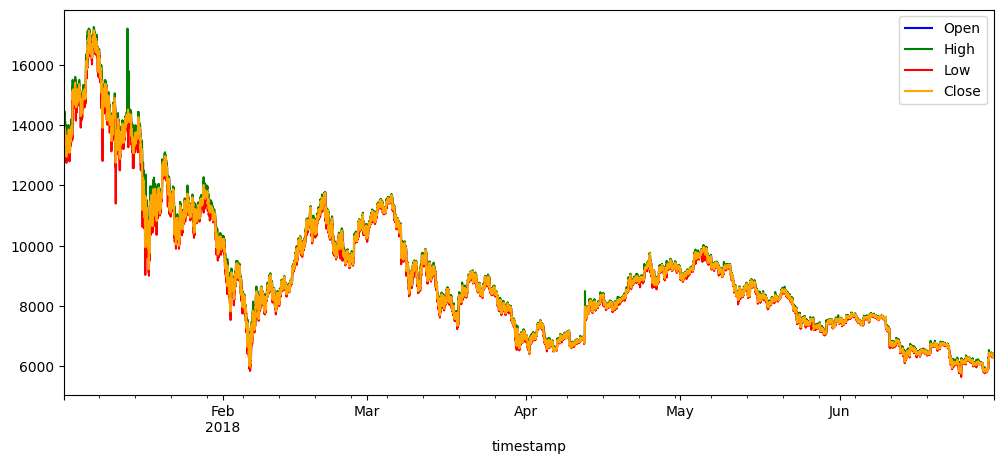

In [72]:
_ = btc_2018[Utils.OHLC].plot()

In [77]:
btc_2018.shape

(17270, 12)

In [187]:
from sklearn.metrics import confusion_matrix

In [97]:
from xgboost import *
import time

In [ ]:
# Test on WF

# Splitting X/Y
X = btc_2018.copy() # X as a deep copy for security reason
Y = X.pop("Target")

# Defining the number of train points and number of records
n_train = 5_000
n_records = 5_200 #len(btc_2018)//2

# Declaring the 
model = XGBClassifier(learning_rate=0.02, n_estimators=600)

# Model name (on-disk storage)
MODEL_NAME = "model_1"

# Horizon lags
HORIZON_LAGS = {
    "future": 10,
    "past": None
}

# Metrics
METRICS = {
    "train_size": {}, # Shape of the train set
    "test_size": {}, # Shape of the test set
    "exec_time": {}, # Execution (fitting + prediction) time
    "model_size": {} # File size of the on-disk model
}

# Predictions
preds_cols = ["ts"] + [str(i) for i in range(1, 11)] + ["conf_mat"]
preds = pd.DataFrame(columns=preds_cols)

for k, i in enumerate(range(n_train, n_records)):
    print(i)
    # Train/test split
    X_train = X.iloc[0: i]
    dt_now = list(X_train.index)[-1]
    METRICS["train_size"][dt_now] = len(X_train)
    X_test = X.iloc[i: i + HORIZON_LAGS["future"]]
    METRICS["test_size"][dt_now] = len(X_test)

    Y_train = Y.iloc[0: i]
    Y_test = Y.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Timing the fitting & prediction operations
    start_time = time.time()
    
    # If first iteration, only fit
    if k == 0:
        model.fit(X=X_train, y=Y_train)
    else:
        # If next iterations, fitting using previous knowledge (saved on-disk)
        model.fit(X=X_train, y=Y_train, xgb_model=MODEL_NAME)
    
    # Saving the model for incremental learning (growing filtration)
    model.get_booster().save_model(MODEL_NAME)
    
    # Predicting the 
    Y_pred = model.predict(X=X_test)
    #print(Y_pred)
    
    if k == 0:
        METRICS["model_size"][dt_now] = 0.0
    else:
        METRICS["model_size"][dt_now] = os.path.getsize(MODEL_NAME)/1e6
    
    dur_time = time.time() - start_time
    METRICS["exec_time"][dt_now] = dur_time
    print(f"Exec. time: {dur_time:.3f}s")
    
    # Computing the confusion matrix
    conf_mat = confusion_matrix(y_true=list(Y_test.values), y_pred=list(Y_pred))
    #print(conf_mat)
    
    # Appending the predictions
    preds = preds.append(pd.DataFrame([[dt_now] + list(Y_pred) + [conf_mat]], columns=preds_cols), ignore_index=True)
    
    #print(train.shape, test.shape)

5000
Exec. time: 1.776s
5001
Exec. time: 1.754s
5002
Exec. time: 2.082s
5003
Exec. time: 2.541s
5004
Exec. time: 1.970s
5005
Exec. time: 1.970s
5006
Exec. time: 1.935s
5007
Exec. time: 2.076s
5008
Exec. time: 2.011s
5009
Exec. time: 2.076s
5010
Exec. time: 2.085s
5011
Exec. time: 2.155s
5012
Exec. time: 2.197s
5013
Exec. time: 2.184s
5014
Exec. time: 2.334s
5015
Exec. time: 2.349s
5016
Exec. time: 2.393s
5017
Exec. time: 2.389s
5018
Exec. time: 2.416s
5019
Exec. time: 2.522s
5020
Exec. time: 2.586s
5021
Exec. time: 3.680s
5022
Exec. time: 3.158s
5023
Exec. time: 2.582s
5024
Exec. time: 2.607s
5025
Exec. time: 2.603s
5026
Exec. time: 2.620s
5027
Exec. time: 2.618s
5028
Exec. time: 2.608s
5029
Exec. time: 2.590s
5030
Exec. time: 2.687s
5031
Exec. time: 2.669s
5032
Exec. time: 2.810s
5033
Exec. time: 2.714s
5034
Exec. time: 2.716s
5035
Exec. time: 2.691s
5036
Exec. time: 2.794s
5037
Exec. time: 2.761s
5038
Exec. time: 2.771s
5039
Exec. time: 2.765s
5040
Exec. time: 2.754s
5041
Exec. time:

**References**:
1. https://greyhoundanalytics.com/blog/backtestingpy-a-complete-quickstart-guide/
2. https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot
3. https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [260]:
# Broadcasting into a Pandas DataFrame
METRICS_ = pd.DataFrame(METRICS)

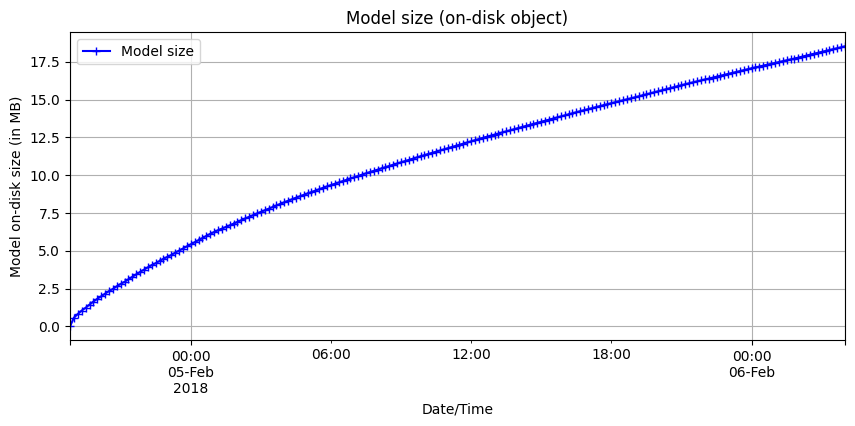

In [261]:
_ = METRICS_["model_size"].plot(marker="+", label="Model size", figsize=(10, 4))
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Model on-disk size (in MB)")
_ = plt.title("Model size (on-disk object)")
_ = plt.legend()

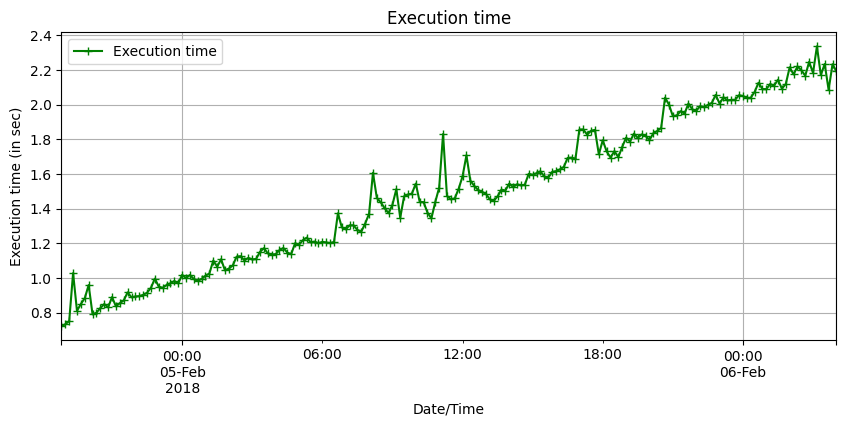

In [262]:
_ = METRICS_["exec_time"].plot(marker="+", label="Execution time", figsize=(10, 4), color="green")
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Execution time (in sec)")
_ = plt.title("Execution time")
_ = plt.legend()

In [264]:
preds["conf_mat"].mean()

array([[3.79 , 2.31 ],
       [2.915, 0.985]])

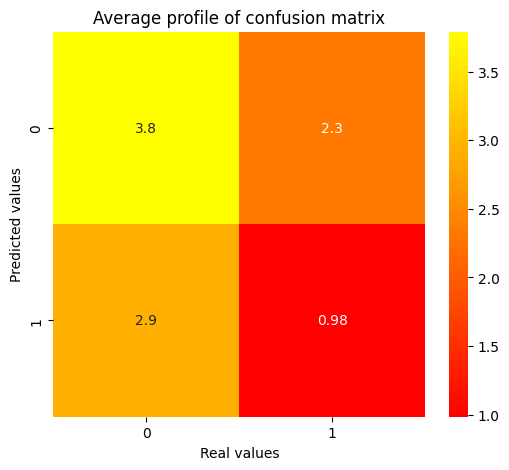

In [265]:
_ = plt.figure(figsize=(6, 5))
_ = sns.heatmap(preds["conf_mat"].mean(), annot=True, cmap="autumn")
_ = plt.title("Average profile of confusion matrix")
_ = plt.xlabel("Real values")
_ = plt.ylabel("Predicted values")

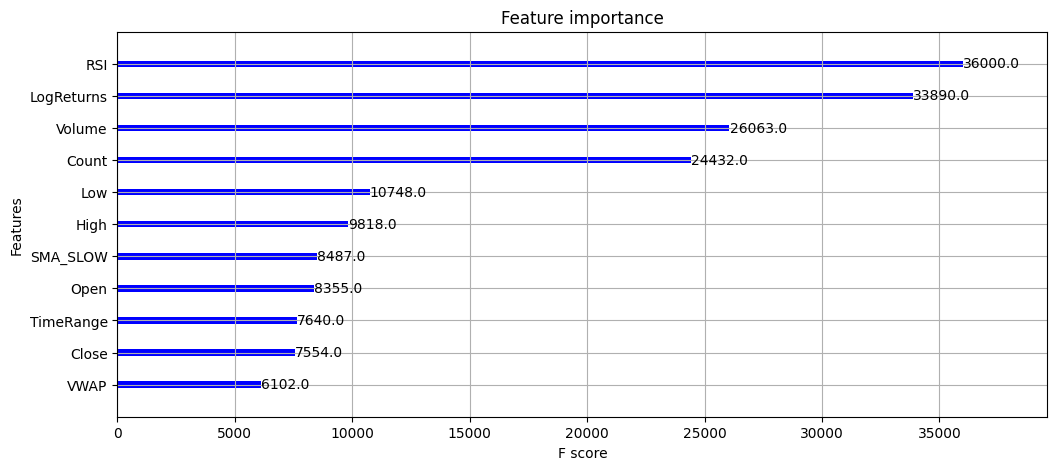

In [255]:
# Plot features 
_ = plot_importance(booster=model.get_booster())

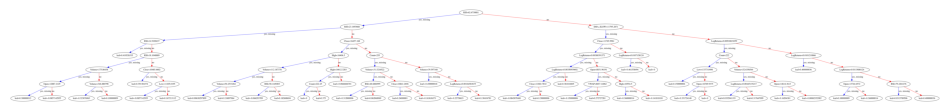

In [258]:
_ = plot_tree(booster=model.get_booster())

In [408]:
# Defining the trading strategy
import datetime
import xgboost
import pandas_ta as tap
import pandas as pd
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import EURUSD
from backtesting.lib import resample_apply

# Dataset
btc_2018 = df["2018": "2018"]

class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 3

    # Do as much initial computation as possible
    def init(self):
        self.daily_rsi = self.I(tap.rsi, pd.Series(self.data.Close), self.rsi_window)
    
    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        #print(len(self.data.df))
        price = self.data.df.iloc[-1]
        #print(type(price))
        
        
        # Use the history (thanks to the I (indicator function)) + 
        # Use the prediction for the l (future lag) next 10 iterations from now on 
        # To do so, we are taking the current_dt and adding the delta (l: future lag to get a dataframe/series
        # with our different predicted models (binary target and/or another ))
        # For instance, check whether we have an increasing/decreasing trend for the next values
        
        current_dt = price.name
        #print(current_dt, price["Close"])
        #print("---")
        self.hello_world()
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()

        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy()

In [409]:
class BT(Backtest):
    def __init__(self, *args, **kwargs):
        print("Initializing the backtest instance ...")
        super().__init__(*args, **kwargs)
        self._strategy.hello_world = lambda x: x == 1
    
    def run(self, *args, **kwargs):
        print("Running ...")
        return super().run(*args, **kwargs)

In [410]:
bt = BT(btc_2018[0: 40000], RsiOscillator, cash=10_000, commission=.002)

Initializing the backtest instance ...


In [411]:
# Defining the backtesting object for the given strategy
#bt = Backtest(btc_2018[0: 10000], RsiOscillator, cash=10_000, commission=.002)

In [412]:
# Running the backtesting operation
stats = bt.run()

Running ...


In [413]:
# Defining the current timestamp (string representation)
dt_now = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")

# Plotting the results curves (in the Jupyter notebook)
_ = bt.plot()

# Saving on-disk the results curves as HTML page
_ = bt.plot(filename=f"../out/backtests/plots/plots_{dt_now}")

# Collecting statistical output from backtest
bt_results = stats

In [414]:
# Getting the statistical output from backtest (broadcasting into a Python dict from a BT stat type)
bt_results_ = {k:v for k, v in bt_results.items() if k not in ["_trades", "_equity_curve", "_strategy"]}

# Getting the output strategy instance
bt_strategy = bt_results["_strategy"]

# Getting the equity curve
bt_equity_curve = bt_results["_equity_curve"]

# Getting the trades table
bt_trades = bt_results["_trades"]

In [417]:
# Saving on-disk 
bt_trades.to_csv(f"../out/backtests/trades/trades_{dt_now}.csv")
bt_equity_curve.to_csv(f"../out/backtests/equity_curves/ec_{dt_now}.csv")

In [418]:
bt_results_

{'Start': Timestamp('2018-01-01 06:20:00'),
 'End': Timestamp('2018-10-06 00:50:00'),
 'Duration': Timedelta('277 days 18:30:00'),
 'Exposure Time [%]': 10.290000000000001,
 'Equity Final [$]': 5901.450786002049,
 'Equity Peak [$]': 10965.349325351663,
 'Return [%]': -40.985492139979506,
 'Buy & Hold Return [%]': -51.883460852176796,
 'Return (Ann.) [%]': -49.839913894013,
 'Volatility (Ann.) [%]': 17.17581866075471,
 'Sharpe Ratio': 0.0,
 'Sortino Ratio': 0.0,
 'Calmar Ratio': 0.0,
 'Max. Drawdown [%]': -47.014418811969314,
 'Avg. Drawdown [%]': -12.325091968732046,
 'Max. Drawdown Duration': Timedelta('252 days 10:30:00'),
 'Avg. Drawdown Duration': Timedelta('52 days 07:00:00'),
 '# Trades': 374,
 'Win Rate [%]': 56.951871657754005,
 'Best Trade [%]': 4.786282716537116,
 'Worst Trade [%]': -7.421759604369271,
 'Avg. Trade [%]': -0.1486868546490716,
 'Max. Trade Duration': Timedelta('0 days 08:40:00'),
 'Avg. Trade Duration': Timedelta('0 days 01:41:00'),
 'Profit Factor': 0.76489620

In [416]:
btc_2018[:][2:26]

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:40:00,260.0,13718.2380,14442.9,13644.990000,13801.032000,49.739558,13780.980585,0,0.006006,1,...,0.665895,-0.160000,-1.2720,74.396604,13759.686806,13586.581100,13413.475394,13670.950800,13626.582200,13616.111600
2018-01-01 06:50:00,278.5,13801.0340,14141.0,13713.260000,13868.724000,54.396066,13859.155262,0,0.004893,1,...,0.881893,0.002000,82.7960,78.243280,13813.613911,13601.832700,13390.051489,13736.937600,13649.835600,13638.266533
2018-01-01 07:00:00,296.0,13865.9440,14224.0,13738.980000,13917.490000,26.822479,13888.212163,0,0.003510,0,...,0.941397,-2.780000,64.9100,80.578886,13870.985494,13620.233200,13369.480906,13804.252800,13681.119400,13661.168267
2018-01-01 07:10:00,273.5,13928.5560,14200.0,13600.000000,13784.644000,37.799960,13852.301551,0,-0.009591,1,...,0.819162,11.066000,62.6120,60.817291,13888.422029,13634.616100,13380.810171,13818.057600,13704.379400,13672.589467
2018-01-01 07:20:00,157.5,13789.4440,14052.6,13605.090000,13811.102000,30.676385,13794.868481,0,0.001918,0,...,0.739362,4.800000,-139.1120,62.834305,13904.044279,13652.050000,13400.055721,13836.598400,13729.039200,13683.125467
2018-01-01 07:30:00,170.5,13798.3620,14123.0,13650.000000,13786.030000,21.834104,13811.795528,0,-0.001817,0,...,0.628951,-12.740000,8.9180,59.603747,13904.399418,13670.483200,13436.566982,13833.598000,13752.274400,13695.587467
2018-01-01 07:40:00,218.0,13789.5480,14030.1,13555.980000,13688.578000,47.322837,13725.840631,0,-0.007094,0,...,0.299656,3.518000,-8.8140,48.773794,13903.824329,13678.092100,13452.359871,13797.568800,13767.253200,13699.080000
2018-01-01 07:50:00,168.5,13691.3080,14060.0,13555.020000,13682.164000,22.559285,13694.412312,0,-0.000469,0,...,-0.196369,2.730000,-98.2400,48.134203,13904.121117,13683.502100,13462.883083,13750.503600,13777.378200,13704.247467
2018-01-01 08:00:00,164.0,13680.1860,14120.4,13520.000000,13620.555000,20.852116,13648.916404,0,-0.004513,1,...,-0.496338,-1.978000,-11.1220,42.224649,13904.044745,13683.863550,13463.682355,13717.685800,13767.871700,13708.814867


In [419]:
X[:].iloc[-1].name

Timestamp('2022-01-24 00:00:00', freq='10T')